In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact

torch.set_grad_enabled(False)

In [3]:
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline
from text3d2video.pipelines.generative_rendering_pipeline import GrPipeline
from text3d2video.pipelines.new_gr_pipeline import GrPipelineNew
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texturing_pipeline import TexGenPipeline

gr_pipe: GrPipelineNew = load_pipeline(GrPipelineNew)

texturing_pipe: TexGenPipeline = TexGenPipeline(
    gr_pipe.vae,
    gr_pipe.text_encoder,
    gr_pipe.tokenizer,
    gr_pipe.unet,
    gr_pipe.scheduler,
    gr_pipe.controlnet,
)

old_gr_pipe = GrPipeline(
    vae=gr_pipe.vae,
    text_encoder=gr_pipe.text_encoder,
    tokenizer=gr_pipe.tokenizer,
    unet=gr_pipe.unet,
    scheduler=gr_pipe.scheduler,
    controlnet=gr_pipe.controlnet,
)

controlnet_pipe = BaseControlNetPipeline(
    vae=gr_pipe.vae,
    text_encoder=gr_pipe.text_encoder,
    tokenizer=gr_pipe.tokenizer,
    unet=gr_pipe.unet,
    scheduler=gr_pipe.scheduler,
    controlnet=gr_pipe.controlnet,
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
tgt_tag = "mma_20:latest"
tgt_tag = "mv_helmet:latest"
tgt_tag = "ymca_20:latest"
tgt_tag = "mv_helmet_25:latest"
tgt_tag = "owl_zoom:latest"
tgt_tag = "rumba_zoom_side:latest"
tgt_tag = "rumba_zoom_20:latest"
tgt_tag = "mv_lion:latest"
tgt_tag = "lion_zoom:latest"
tgt_tag = "mv_cat_statue_25:latest"
tgt_tag = "catwalk_180_20:latest"
tgt_tag = "flair_20:latest"
tgt_tag = "handstand_20:latest"
tgt_tag = "rumba_20:latest"
tgt_tag = "joyful_jump_20:latest"

tgt_art = AnimationArtifact.from_wandb_artifact_tag(tgt_tag)
tgt_seq = tgt_art.read_anim_seq([0, 7, 8, 9, 12])

src_tag = "catwalk_180_src:latest"
src_tag = "ymca_zoom_out:latest"
src_tag = "rumba_zoom_src:latest"
src_tag = "owl_zoom_src:latest"
src_tag = "rumba_zoom_out_src:latest"
src_tag = "mv_helmet:latest"
src_tag = "mv_cat_statue:latest"
src_tag = "human_mv:latest"
src_tag = "human_T_front:latest"

src_art = AnimationArtifact.from_wandb_artifact_tag(src_tag)
src_seq = src_art.read_anim_seq()

In [56]:
from text3d2video.rendering import render_texture
from text3d2video.util import chw_to_hwc
from text3d2video.utilities.testing_utils import checkerboard_img
from text3d2video.utilities.video_comparison import display_vid, video_grid
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
input_src_anim = None
input_src_anim = src_seq

def inputs_video(prompt, src_seq, tgt_seq):
    texture = checkerboard_img(return_type="pt", res=500, square_size=30).cuda()
    texture = chw_to_hwc(texture)

    vids = {}

    if src_seq is not None:
        src_frames = render_texture(
            src_seq.meshes,
            src_seq.cams,
            texture,
            src_seq.verts_uvs,
            src_seq.faces_uvs,
            return_pil=True,
        )

        vids["src"] = pil_frames_to_clip(src_frames)

    anim_frames = render_texture(
        tgt_seq.meshes,
        tgt_seq.cams,
        texture,
        tgt_seq.verts_uvs,
        tgt_seq.faces_uvs,
        return_pil=True,
    )

    tgt_vid = pil_frames_to_clip(anim_frames, fps=12)
    vids["tgt"] = tgt_vid

    vids_list = list(vids.values())
    titles = list(vids.keys())
    return video_grid(
        [vids_list], x_labels=titles, padding_mode="slow_down", y_labels=[prompt]
    )

display_vid(inputs_video(prompt, src_seq, tgt_seq))

100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


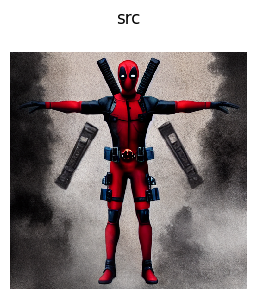

In [57]:
from text3d2video.utilities.ipython_utils import display_ims

prompts = [prompt] * len(src_seq)
depths = src_seq.render_depth_maps()

generator = torch.Generator(device="cuda").manual_seed(0)
out_src = controlnet_pipe(prompts, depths, num_inference_steps=15, generator=generator)

display_ims(out_src.images, title="src")

In [58]:
from pathlib import Path
from torch import Generator
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import H5Logger

seed = 0

generator = torch.Generator(device="cuda").manual_seed(seed)
tgt_cn = controlnet_pipe(
    [prompt] * len(tgt_seq),
    tgt_seq.render_depth_maps(),
    num_inference_steps=15,
    generator=generator,
)


gr_config = GenerativeRenderingConfig(
    num_inference_steps=15,
    do_pre_attn_injection=True,
    do_post_attn_injection=False,
    attend_to_self_kv=True,
)

generator = Generator(device="cuda").manual_seed(seed)
tgt_pre_only = gr_pipe(
    prompt,
    tgt_seq,
    src_seq,
    out_src.latents,
    gr_config,
    initial_texture=None,
    multires_textures=True,
    generator=generator,
)


logger = H5Logger(Path("data.h5"))
logger.key_greenlists["layer"] = ["up_blocks.3.attentions.0.transformer_blocks.0.attn1"]
logger.delete_data()
logger.open_write()

gr_config = GenerativeRenderingConfig(
    num_inference_steps=15,
    do_pre_attn_injection=False,
    do_post_attn_injection=True,
    guidance_scale=7.5,
    feature_blend_alpha=0.8,
    attend_to_self_kv=True,
)

generator = Generator(device="cuda").manual_seed(0)

tgt_both = gr_pipe(
    prompt,
    tgt_seq,
    src_seq,
    out_src.latents,
    gr_config,
    initial_texture=None,
    texture_noise_level=0.1,
    multires_textures=True,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


[[0]]
[0, 0, 0, 0, 0]


100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


[[0]]
[0, 0, 0, 0, 0]


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


In [59]:
keys_and_vals = logger.field_keys_and_vals("feats_cond")
layer = keys_and_vals["layer"][0]
t = keys_and_vals["t"][0]

frame_is = logger.field_keys_and_vals("renders_cond")["frame_i"]
print(frame_is)

feat_kwargs = {
    "layer": layer,
    "t": t,
}

src_frame_i = keys_and_vals["src_frame_i"][0]
feats = logger.read("feats_cond", src_frame_i=src_frame_i, **feat_kwargs)

rendered_feats = [
    logger.read("renders_cond", frame_i=i, **feat_kwargs) for i in frame_is
]

rendered_feats = torch.stack(rendered_feats)

[0, 1, 2, 3, 4]


In [1]:
from einops import rearrange

from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.utilities.ipython_utils import display_ims

feats_flat = rearrange(feats, 'c h w -> (h w) c')
pca = RgbPcaUtil.init_from_features(feats_flat)

# src_rgb = pca.feature_map_to_rgb_pil(feats)
# tgt_rgb = [pca.feature_map_to_rgb_pil(f) for f in rendered_feats]

NameError: name 'feats' is not defined

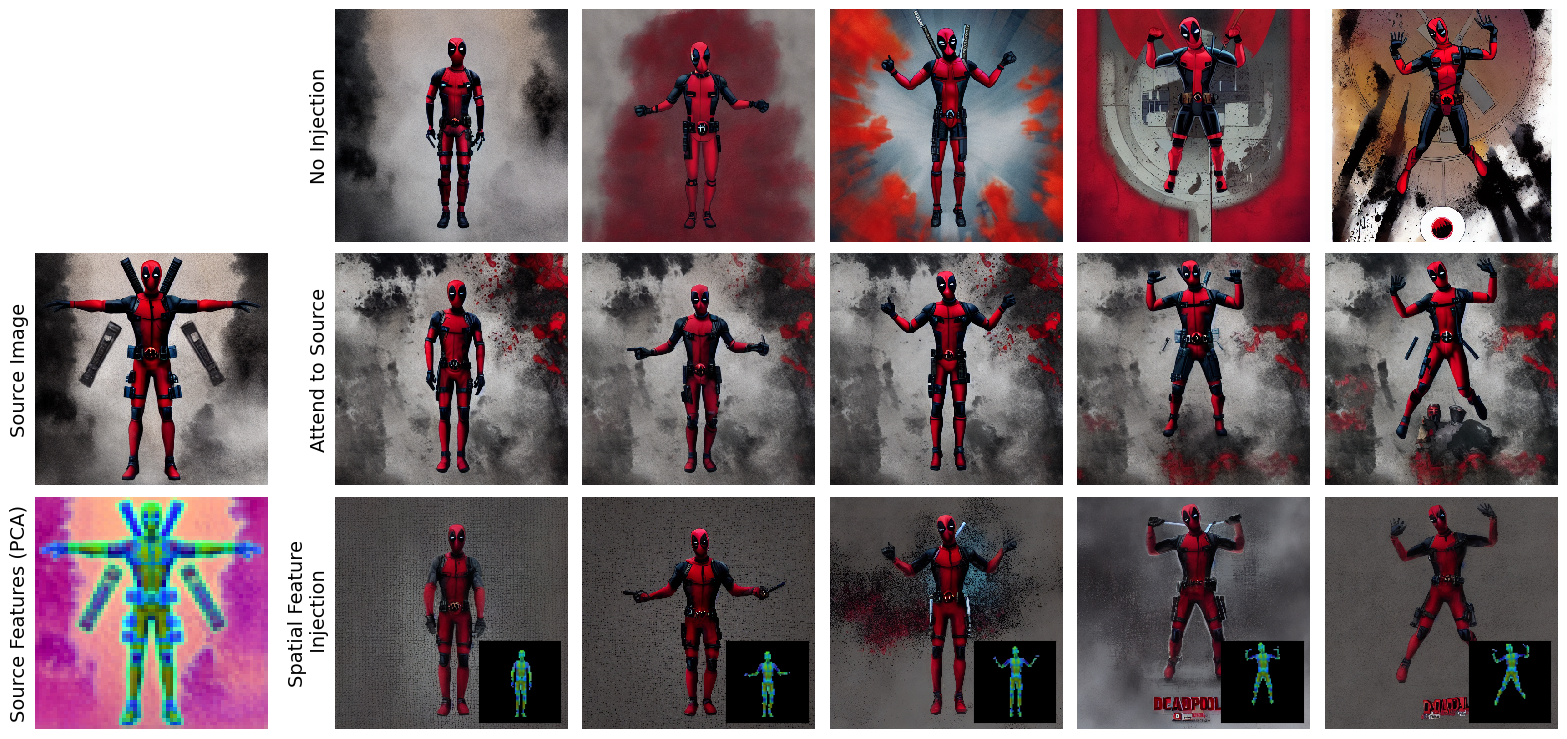

In [61]:
from text3d2video.utilities.ipython_utils import display_ims_grid
from text3d2video.utilities.matplotlib_utils import add_inset

src_im = out_src.images[0]

row_cn = [src_im] + tgt_cn.images
row_pre_only = [src_im] + tgt_pre_only.images
row_both = [src_rgb] + tgt_post.images

fig_ims = [row_cn, row_pre_only, row_both]

fig, axs = display_ims_grid(fig_ims, show=False)

rgbs = [src_rgb] + tgt_rgb

for i, ax in enumerate(axs[-1, :]):
    if i > 0:
        axins = add_inset(ax, width="35%", loc='lower right')
        axins.imshow(rgbs[i])

fig.delaxes(axs[0,0])
fontsize=14
axs[1,0].set_ylabel('Source Image', fontsize=fontsize)
axs[2,0].set_ylabel('Source Features (PCA)', fontsize=fontsize)

axs[0,1].set_ylabel("No Injection", fontsize=fontsize)
axs[1,1].set_ylabel("Attend to Source", fontsize=fontsize)
axs[2,1].set_ylabel("Spatial Feature\n Injection", fontsize=fontsize)

src_axs = axs[1:,0]
for ax in src_axs:
    offset = 0.035
    pos = ax.get_position()
    new_pos = [pos.x0 - offset, pos.y0, pos.width, pos.height]  # Shift left by 0.05
    ax.set_position(new_pos)

# plt.savefig("outs/injections.pdf", bbox_inches="tight", dpi=300)